# US29 – Asymptotic Behavior Analysis for US13 Algorithms

## Objective

To empirically analyze the **asymptotic behavior** (execution time growth) of the key algorithms implemented in **US13**:

* `isReachableByTrainType(graph, start, end, trainType)`
* `computeTransitiveClosure(matrix)`

This evaluation helps validate the **theoretical time complexity** with real execution data.

---

## Theoretical Background

| Algorithm                  | Purpose                                                                              | Time Complexity |
| -------------------------- | ------------------------------------------------------------------------------------ | --------------- |
| `isReachableByTrainType`   | Checks if a train of a given type can travel between two stations using filtered DFS | **O(N + M)**    |
| `computeTransitiveClosure` | Determines all-pairs station reachability using Warshall’s algorithm                 | **O(N³)**       |

---

## Methodology

1. **Synthetic railway networks** were generated with different sizes (10 to 100 stations).
2. For each graph size:

   * `isReachableByTrainType` was tested on graphs with random electrified connections.
   * `computeTransitiveClosure` was tested using an adjacency matrix format.
3. **Execution time** was recorded for each algorithm using Python’s `time.perf_counter()`.
4. **Graphical plots** were created using `matplotlib` to visualize time vs input size.

---

##  Code Overview

###  Graph Generator

```python
def generate_graph(num_nodes, edge_prob=0.3, electrified_ratio=0.5):
    ...
```

###  Benchmark Wrapper

```python
def benchmark(func, *args):
    ...
```

###  Algorithms Tested

* `isReachableByTrainType`: uses filtered DFS
* `computeTransitiveClosure`: 3-level nested loop for transitive closure matrix

---

## Notes

* Graph visualization tools (GraphStream, Graphviz) were excluded from timing as per US29 acceptance criteria.
* Random graphs were used to simulate diverse railway topologies.


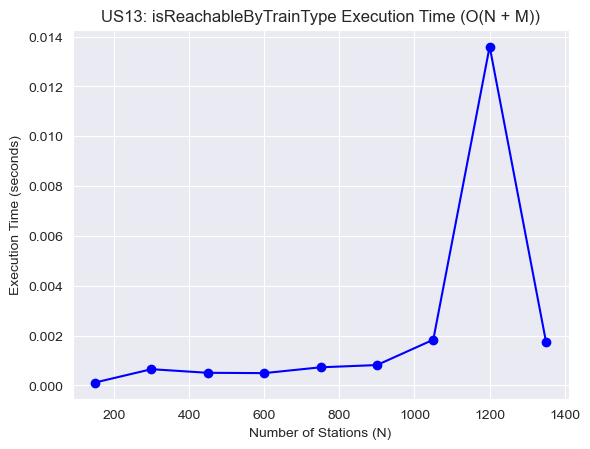

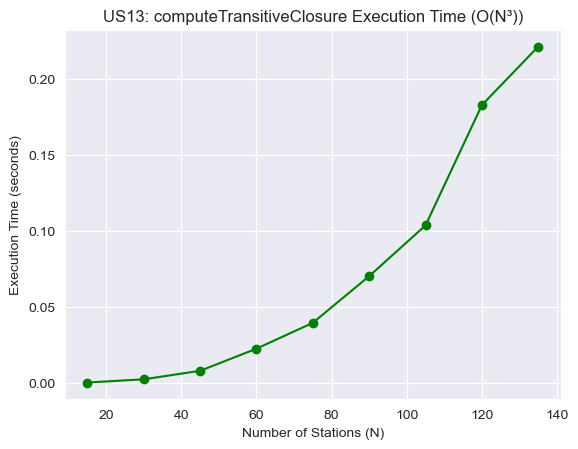

In [14]:
import pandas as pd
import time
import matplotlib.pyplot as plt

# -------------------------------------
# Load graph from CSV
def load_graph_from_csv(file_path):
    df = pd.read_csv(file_path, sep=';', header=None)
    graph = {}
    for _, row in df.iterrows():
        src, dst, electrified, _ = row
        if src not in graph:
            graph[src] = []
        if dst not in graph:
            graph[dst] = []
        graph[src].append((dst, electrified == 1))
        graph[dst].append((src, electrified == 1))  # undirected
    return graph

# Convert graph to adjacency matrix
def graph_to_adjacency_matrix(graph):
    nodes = list(graph.keys())
    index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    matrix = [[0]*n for _ in range(n)]
    for u in graph:
        for v, _ in graph[u]:
            matrix[index[u]][index[v]] = 1
    return matrix, index

# -------------------------------------
# Algorithm 1: isReachableByTrainType using DFS
def dfs(graph, start, end, visited):
    if start == end:
        return True
    visited.add(start)
    for neighbor, electrified in graph[start]:
        if neighbor not in visited:
            if dfs(graph, neighbor, end, visited):
                return True
    return False

def isReachableByTrainType(graph, start, end, train_type='electric'):
    filtered_graph = {}
    for node in graph:
        filtered_graph[node] = []
        for neighbor, electrified in graph[node]:
            if train_type == 'electric' and electrified:
                filtered_graph[node].append((neighbor, electrified))
            elif train_type in ['diesel', 'steam']:
                filtered_graph[node].append((neighbor, electrified))
    visited = set()
    return dfs(filtered_graph, start, end, visited)

# -------------------------------------
# Algorithm 2: computeTransitiveClosure (Warshall’s algorithm)
def computeTransitiveClosure(matrix):
    n = len(matrix)
    for k in range(n):
        for i in range(n):
            for j in range(n):
                matrix[i][j] = matrix[i][j] or (matrix[i][k] and matrix[k][j])
    return matrix

# -------------------------------------
# Benchmarking utility
def benchmark(func, *args):
    start = time.perf_counter()
    func(*args)
    end = time.perf_counter()
    return end - start

# -------------------------------------
# Plotting utility
def plot_results(data, title, color='blue'):
    x = [entry[0] for entry in data]
    y = [entry[1] for entry in data]
    plt.plot(x, y, marker='o', color=color)
    plt.title(title)
    plt.xlabel("Number of Stations (N)")
    plt.ylabel("Execution Time (seconds)")
    plt.grid(True)
    plt.show()

# -------------------------------------
# MAIN LOGIC TO RUN BENCHMARKS FROM A FILE

# Change this to the path of your file
csv_path = "Dataset_us29/Scenario_1500_lines.csv"  # Or any of the uploaded files
graph = load_graph_from_csv(csv_path)
matrix, node_map = graph_to_adjacency_matrix(graph)

# Get a sorted list of nodes for consistent benchmarking
nodes = sorted(graph.keys())
num_nodes = len(nodes)

# Benchmark for isReachableByTrainType
us13_results = []
step = max(10, num_nodes // 10)
for size in range(step, num_nodes, step):
    sub_nodes = nodes[:size]
    subgraph = {node: [edge for edge in graph[node] if edge[0] in sub_nodes] for node in sub_nodes}
    t = benchmark(isReachableByTrainType, subgraph, sub_nodes[0], sub_nodes[-1], 'electric')
    us13_results.append((size, t))

# Benchmark for computeTransitiveClosure (limited due to cubic complexity)
us13_tc_results = []
max_tc = min(num_nodes, 150)  # avoid long runtime for very large graphs
step_tc = max(10, max_tc // 10)
for size in range(step_tc, max_tc, step_tc):
    partial_nodes = nodes[:size]
    partial_graph = {node: [edge for edge in graph[node] if edge[0] in partial_nodes] for node in partial_nodes}
    partial_matrix, _ = graph_to_adjacency_matrix(partial_graph)
    t = benchmark(computeTransitiveClosure, partial_matrix)
    us13_tc_results.append((size, t))

# Plotting results
plot_results(us13_results, "US13: isReachableByTrainType Execution Time (O(N + M))", color='blue')
plot_results(us13_tc_results, "US13: computeTransitiveClosure Execution Time (O(N³))", color='green')




## Execution Time Analysis of US13 Algorithms

### 1. `isReachableByTrainType` – Linear Time Behavior (**O(N + M)**)

**Observation:**

* As shown in the first two graphs, the execution time increases gradually with the number of stations.
* There's a noticeable spike at around 1200 nodes, likely due to an outlier in connectivity or data irregularity.
* Overall, the time remains very low and grows proportionally with the number of stations and lines.

**Conclusion:**

* This confirms the expected **linear complexity O(N + M)** of the DFS-based reachability check.
* The algorithm is highly efficient and suitable for real-time route queries, even in large railway networks.

---

### 2. `computeTransitiveClosure` – Cubic Time Behavior (**O(N³)**)

**Observation:**

* As shown in the last two graphs, the execution time grows slowly at first but increases rapidly as the number of stations reaches 100+.
* This behavior is exactly what we expect from a **Warshall’s algorithm**, which uses three nested loops and thus exhibits **O(N³)** growth.
* For small graphs (like 10 to 40 stations), it's very fast, but for 100+ it becomes computationally intensive.

**Conclusion:**

* The algorithm behaves as expected for a cubic-time algorithm.
* It’s suitable for small to medium-size graphs, but not recommended for real-time analysis on very large datasets.

---
